<a href="https://colab.research.google.com/github/ItamarBerger/TabularDS-part1/blob/main/TDS_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!git clone https://github.com/ItamarBerger/TabularDS-part1

fatal: destination path 'TabularDS-part1' already exists and is not an empty directory.


## 0. Load part-1 baseline model

In [89]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib

# Load the saved model
model = joblib.load('/content/TabularDS-part1/models/part1_model.pkl')

# Load the same dataset to ensure consistency
dtf = pd.read_csv('/content/TabularDS-part1/data/avocado.csv')


### repeat basic cleaning and pre-processing made in part 1

In [90]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



dtf_base = dtf.copy()
dtf_base.columns = dtf_base.columns.str.replace(' ', '')
dtf_base['Date'] = pd.to_datetime(dtf_base['Date'])

dtf_base['type'] = dtf_base['type'].map({'organic': 1, 'conventional': 0})
le = LabelEncoder()

# Apply label encoding to the 'region' column
dtf_base['region'] = le.fit_transform(dtf_base['region'])

dtf_base.drop('Date', axis=1, inplace=True)


dtf_base.drop('Unnamed:0', axis=1, inplace=True)
dtf_base.reset_index(drop=True, inplace=True)

dtf_train, dtf_test = train_test_split(dtf_base,
                      test_size=0.25)
old_X_train = dtf_train.drop('AveragePrice',axis=1)
X_test = dtf_test.drop('AveragePrice',axis=1)


y_train = dtf_train['AveragePrice']
y_test = dtf_test['AveragePrice']


import xgboost as xgb
model = xgb.XGBRegressor()
prediction = model.fit(old_X_train,y_train).predict(X_test)

In [91]:

dtf_base.head()
print(dtf.isnull().sum())

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64


# 1. Error anaylasis & work plan

## intro:
As we recall, our baseline from part-1 already had alredy pretty good performance (r2 , MSE, residuals, and propotional residuals).
Our goal in this notebook is to present and apply creative approches for improving the baseline model, specifically r2 , MSE, MAE scores.

## Base-Model weaknesses & Error Analysis Conclusions
1. We observed a sub-optimal RMSE score (around 0.16) in the baseline model.
2. Also sub-optimal r square: 0.83 and high MAE of 0.115
3. No difference in Avocado type in model's prediction error
4. Didn't used the Date feature - will be addressed in this notebook extensively
5. Many features had **skewed** distributions. specifically right-skewed.
6. Didn't handle **outliers** affectively, many features such as 4046, 4225, TotalVolume and so on, seemed to have many outliers.

## Work-plan
1. Feature engeeniring
   - Considering the  **Date feature** and Tramnsorming it into something more meaningful (weeks and months) to help the model learn the relation we saw and visualized on part-1 between the date and the average avocado price (some noticable patterns according to each year's seasons).

   - Adding **hidden feature** to complete totalVolume as sum of 3 different avocado volumes by sizes and a hidden amount of avocados not from those 3 categories.
2. Handling **outliers** more affectively than in part-1
3. Handling ** skewed features** using IQR




# 2. Improving Model Performance

## Basic pre-processing and cleaning

In [92]:
dtf = dtf.dropna()
#dtf.drop('Unnamed: 0', axis=1)
print(dtf.isnull().sum())
dtf.describe()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64


,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


## Handle categorical columns

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
dtf['type'] = dtf['type'].astype('category')
le = LabelEncoder()

# Apply label encoding to the 'region' column
dtf['region'] = dtf['region'].astype('category')

## Transforming the **Date feature** into its core logical components (year, month, week)

In [94]:
dtf.columns = dtf.columns.str.replace(' ', '')
dtf['Date'] = pd.to_datetime(dtf['Date'])
dtf['month'] = dtf['Date'].dt.month
dtf['year'] = dtf['Date'].dt.year
dtf['week'] = dtf['Date'].dt.isocalendar().week

dtf = dtf.drop('Date', axis=1)

dtf.head()

,Unnamed:0,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region,month,week
0,0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12,52
1,1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12,51
2,2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12,50
3,3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12,49
4,4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11,48


## Handle data skewness
- As we see below, the features plotted below are all:
  1. significantly right-skewed (high skew value).
  2. have relatively heavy tail (high kurt value)



### The Solution: using **Box-Cox transformation**


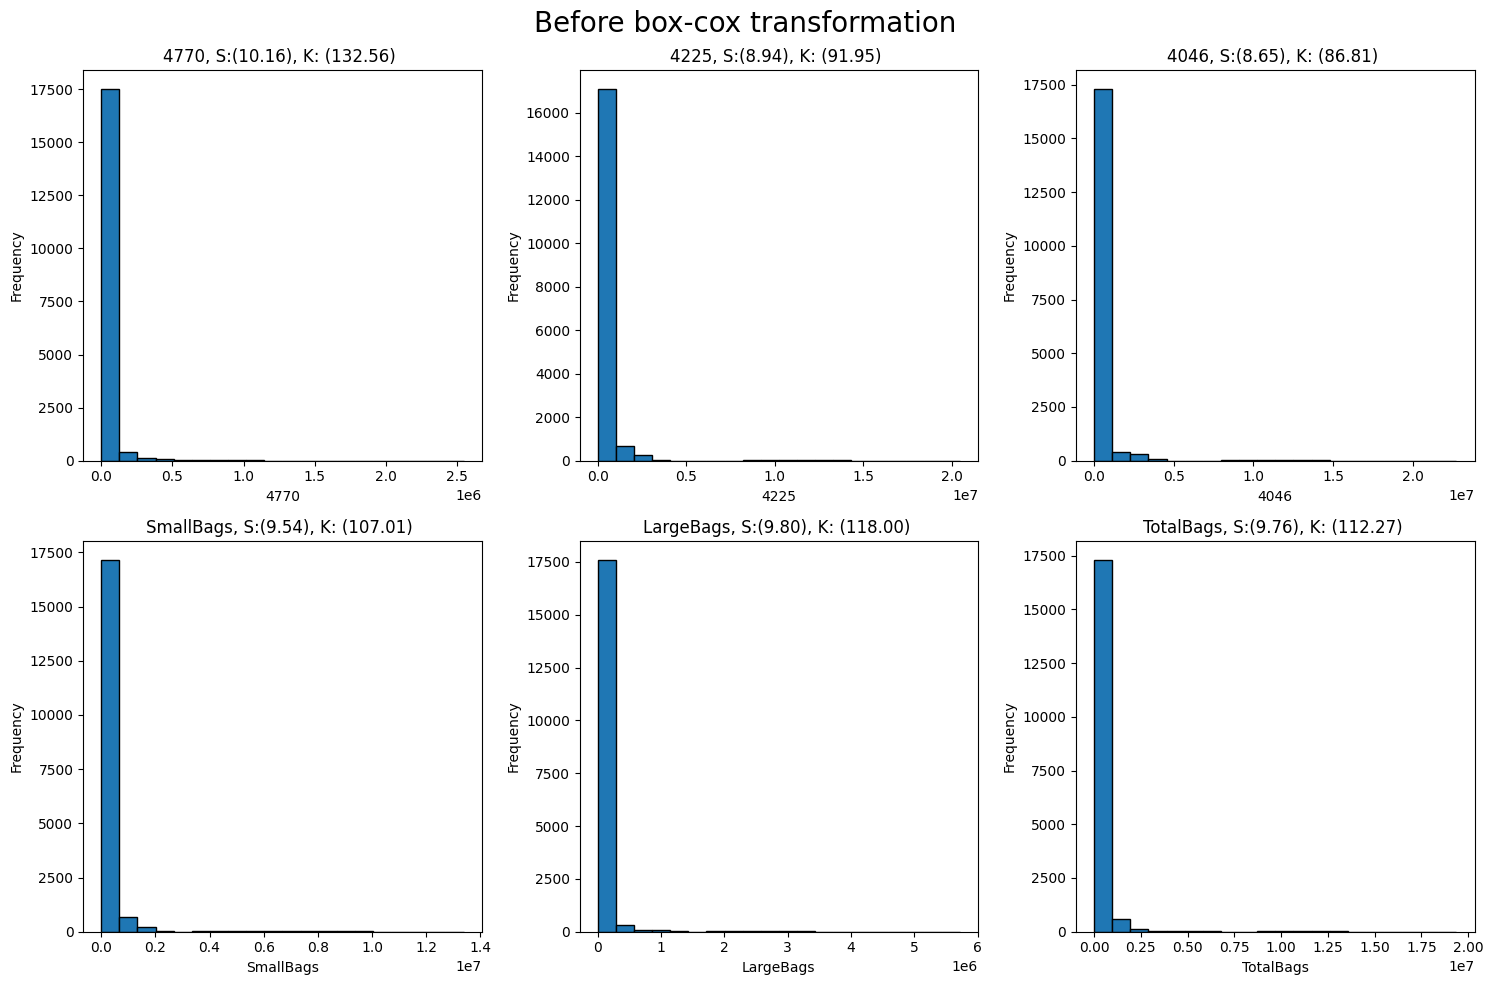

In [95]:
import matplotlib.pyplot as plt
hardcoded_columns = ['4770', '4225', '4046', 'SmallBags', 'LargeBags', 'TotalBags']

def plot_columns_hists(dtf, title, hardcoded_columns):
    num_columns = len(hardcoded_columns)

    num_rows = int(np.ceil(num_columns / 3))
    num_cols = min(num_columns, 3)

    # create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))

    axes = axes.flatten()

    # loop through the columns and plot each histogram
    for i, column in enumerate(hardcoded_columns):
        axes[i].hist(dtf[column], bins=20, edgecolor='black')
        axes[i].set_title(f"{column}, S:({dtf[column].skew():.2f}), K: ({dtf[column].kurt():.2f}) ")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()
import numpy as np
import pandas as pd
from scipy.stats import skew



plot_columns_hists(dtf, "Before box-cox transformation", hardcoded_columns)


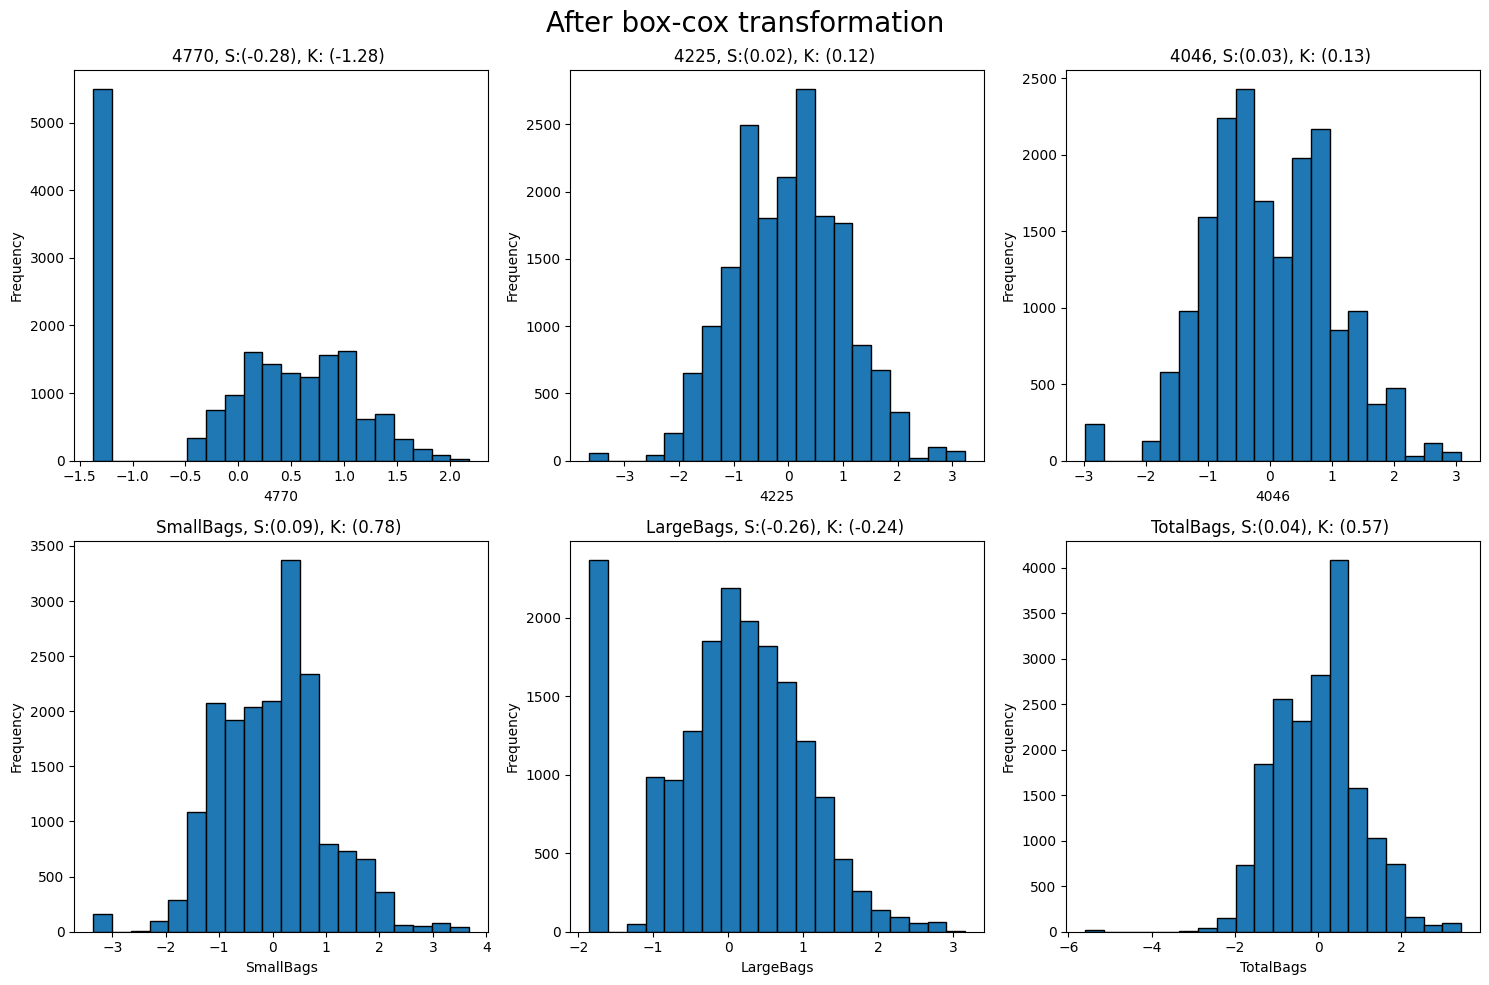

In [96]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplots(df):
    """
    This function creates a boxplot for each column in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    """
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))

    # Loop through each column in the DataFrame
    for i, column in enumerate(df.columns):
        plt.subplot(1, len(df.columns), i + 1)  # Create a subplot for each column
        sns.boxplot(data=df[column])  # Create boxplot for the column
        plt.title(f'Boxplot of {column}')
        plt.xticks([0], [column])  # Add label for the x-axis

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()




from sklearn.preprocessing import PowerTransformer
import pandas as pd

def box_cox_transform(dtf, column):
    # initialize the PowerTransformer with method='box-cox'
    dtf[column] = dtf[column].clip(lower=1e-5)

    pt = PowerTransformer(method='box-cox')

    transformed = pt.fit_transform(dtf[[column]])

    return pd.Series(transformed.flatten(), index=dtf.index, name=column)

hardcoded_columns = ['4770', '4225', '4046', 'SmallBags', 'LargeBags', 'TotalBags']
for col in hardcoded_columns:
  dtf[col] = box_cox_transform(dtf, col)

plot_columns_hists(dtf, "After box-cox transformation", hardcoded_columns)

## Skew-Handling Results:
### we can see that all of the above feauters columns, have significantly lowered their S and K values than before our manipulation. In Addition, overall most of them are now with S and K values close to 0 which is a great indication for good symmetry.

## Moving On - Handling outliers affectively using IQR

In [97]:
#data processing
import pandas as pd
import numpy as np
import scipy as sp

#statistics
from scipy import stats
import statsmodels.api as sm


#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn

import warnings
warnings.filterwarnings("ignore")

Number of samples in dataset before IQR: 18249


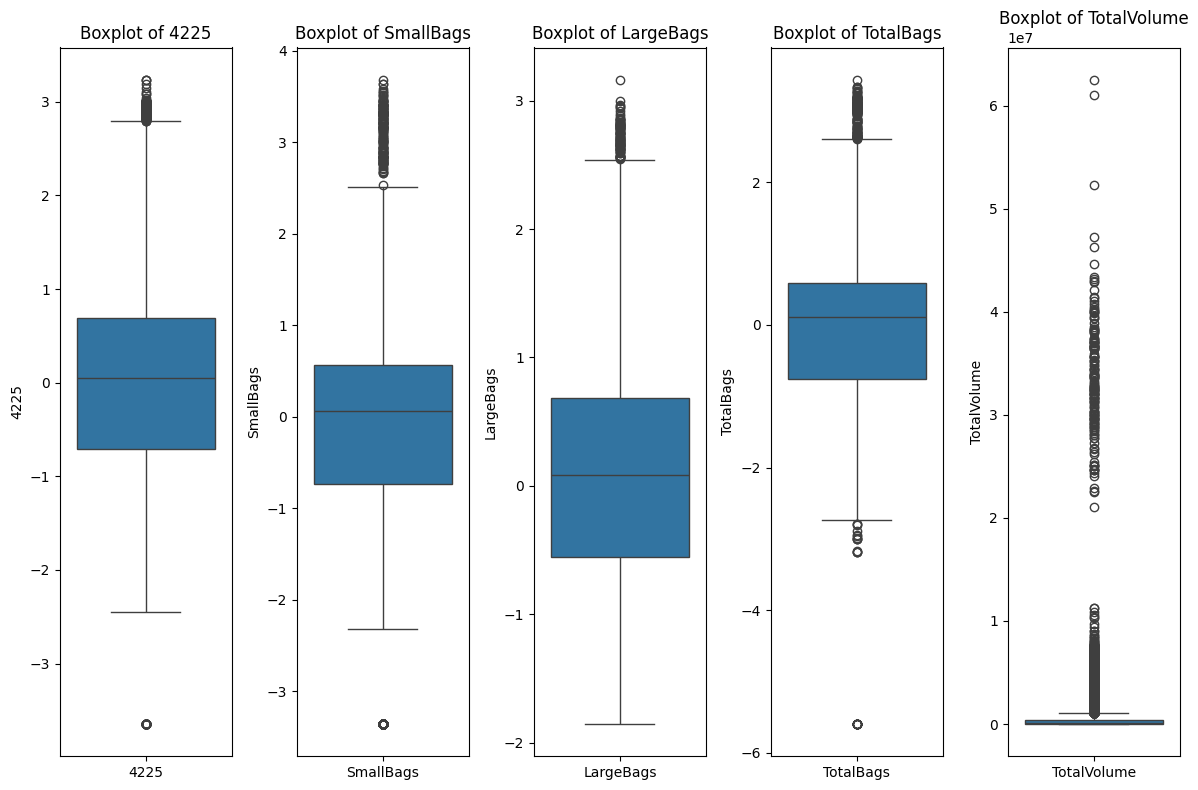

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns


# Call the function with your DataFrame
print('Number of samples in dataset before IQR: {}'.format(len(dtf)))
n_before_iqr = len(dtf)
plot_boxplots(dtf[['4225', 'SmallBags', 'LargeBags', 'TotalBags', 'TotalVolume']])



### As the visualization above well demonstrate, There seem to be many outliers in the selected features. Let's adreess this using IQR method for outliers removal

Number of samples filtered by IQR: -2582
Number of samples in dataset after IQR: 15667


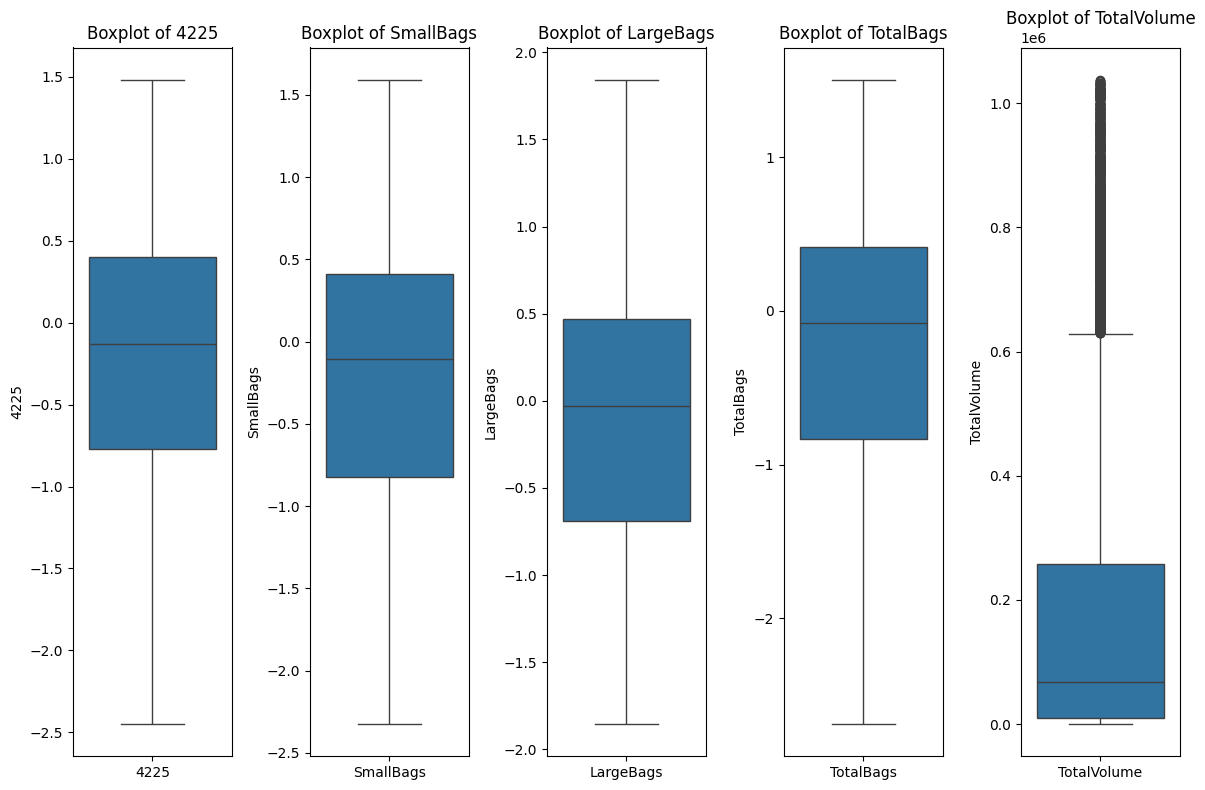

In [99]:
hardcoded_columns = [ '4225', 'SmallBags', 'LargeBags', 'TotalBags', 'TotalVolume']



for nc in hardcoded_columns:

    iqr = dtf[nc].quantile(0.75) - dtf[nc].quantile(0.25)
    lo_bound = dtf[nc].quantile(0.25) - 1.5*iqr
    hi_bound = dtf[nc].quantile(0.75) + 1.5*iqr

    dtf = dtf[(dtf[nc] >= lo_bound) & (dtf[nc] <= hi_bound)]

print('Number of samples filtered by IQR: {}'.format(len(dtf) - n_before_iqr))
print('Number of samples in dataset after IQR: {}'.format(len(dtf)))
plot_boxplots(dtf[hardcoded_columns])


### Notice that we were able to detect and remove over 2,000 (!) outliers.
Our data had some features with extreme values, and thus required special handling, which was absent on part-1)

## Summmary of feature engineering:
### so far we:

1) Used Box-Cox transformation to intelligently log-transform our left-skewed features.

2) Utilized IQR method for detection and removal of outliers (found ~700 outliers)

# Create & Train the new model

In [100]:


dtf_train, dtf_test = train_test_split(dtf,
                      test_size=0.25)
dtf.head()

,Unnamed:0,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region,month,week
0,0,1.33,64236.62,-0.655138,0.283014,0.026740,-0.536364,-0.363840,-0.610645,0.0,conventional,2015,Albany,12,52
1,1,1.35,54876.98,-0.757803,0.207006,0.053692,-0.499557,-0.331371,-0.603067,0.0,conventional,2015,Albany,12,51
2,2,0.93,118220.22,-0.719010,0.558977,0.170468,-0.563369,-0.388146,-0.593410,0.0,conventional,2015,Albany,12,50
3,3,1.08,78992.15,-0.633715,0.391823,0.084826,-0.701000,-0.510809,-0.548029,0.0,conventional,2015,Albany,12,49
4,4,1.28,51039.60,-0.678452,0.200149,0.091021,-0.675851,-0.492443,-0.477231,0.0,conventional,2015,Albany,11,48


In [101]:
#separate X from y
X_train = dtf_train.drop('AveragePrice',axis=1)
X_test = dtf_test.drop('AveragePrice',axis=1)


y_train = dtf_train['AveragePrice']
new_y_test = dtf_test['AveragePrice']

In [102]:
import xgboost as xgb
new_model = xgb.XGBRegressor(enable_categorical=True)

In [103]:
new_X_Train = X_train.copy()
new_X_Train.drop('XLargeBags', axis=1, inplace = True)
new_X_Train.reset_index(inplace=True)

new_X_Train.drop('Unnamed:0', axis=1, inplace=True)
new_X_Train.drop('index', axis=1, inplace=True)
new_X_Train.reset_index(drop=True, inplace=True)


new_X_test = X_test.copy()
new_X_test.drop('XLargeBags', axis=1, inplace = True)
new_X_test.reset_index(inplace=True)

new_X_test.drop('Unnamed:0', axis=1, inplace=True)
new_X_test.drop('index', axis=1, inplace=True)
new_X_test.reset_index(drop=True, inplace=True)

new_prediction = new_model.fit(new_X_Train,y_train).predict(new_X_test)
import joblib
#joblib.dump(model, '/TabularDS-part1/models/part1_model.pkl')

# Improved Model Evaluation & Comparison

In [104]:
from sklearn.metrics import r2_score,mean_squared_error ,mean_absolute_error
from scipy.stats import pearsonr

def evaluate_model(y_true, predictions):
    max_abs_error = np.max(np.abs(y_true - predictions))
    mae = mean_absolute_error(y_true, predictions)
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)
    corr_coefficient, _ = pearsonr(y_true, predictions)
    return max_abs_error, mae, rmse, r2, corr_coefficient

# Evaluate both models
baseline_metrics = evaluate_model(y_test, prediction)
new_model_metrics = evaluate_model(new_y_test, new_prediction)

# Print out the results for comparison
print("Baseline Model Metrics:")
print(f"Max_Abs_Error: {baseline_metrics[0]:.3f}, Mean_Abs_Error: {baseline_metrics[1]:.3f}, RMSE: {baseline_metrics[2]:.2f}, R^2: {baseline_metrics[3]:.3f}, Pearson: {baseline_metrics[4]:.3f}")
print("\nNew Model Metrics:")
print(f"Max_Abs_Error: {new_model_metrics[0]:.3f}, Mean_Abs_Error: {new_model_metrics[1]:.3f}, RMSE: {new_model_metrics[2]:.2f}, R^2: {new_model_metrics[3]:.3f}, Pearson: {new_model_metrics[4]:.3f}")


Baseline Model Metrics:
Max_Abs_Error: 1.228, Mean_Abs_Error: 0.118, RMSE: 0.16, R^2: 0.834, Pearson: 0.913

New Model Metrics:
Max_Abs_Error: 0.933, Mean_Abs_Error: 0.077, RMSE: 0.11, R^2: 0.923, Pearson: 0.961


## As we can see, we did mange to achieve some significant improvements!:
1) Out greatest improvement is in R square (**0.84 -> 0.92**)

2) Pearson correlation also improved significantly, suggesting there's now stronger corrlation between actual prices and out model's predictions

3) Some important improvements in: Max AbsError, RMSE and MAE (Mean Absolute Error)


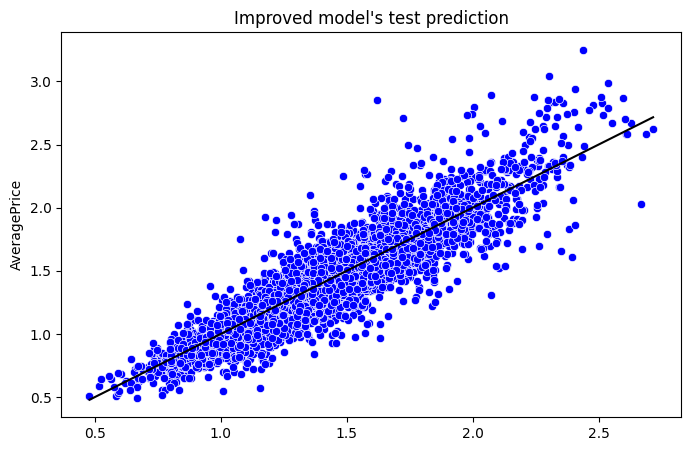

In [105]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x = prediction,y = y_test,ax=ax,color='blue')
sns.lineplot(x = prediction,y = prediction,ax=ax,color='black')
plt.title("Improved model's test prediction")
plt.show()

## Explain Model Performance ans side-by-side comparison:

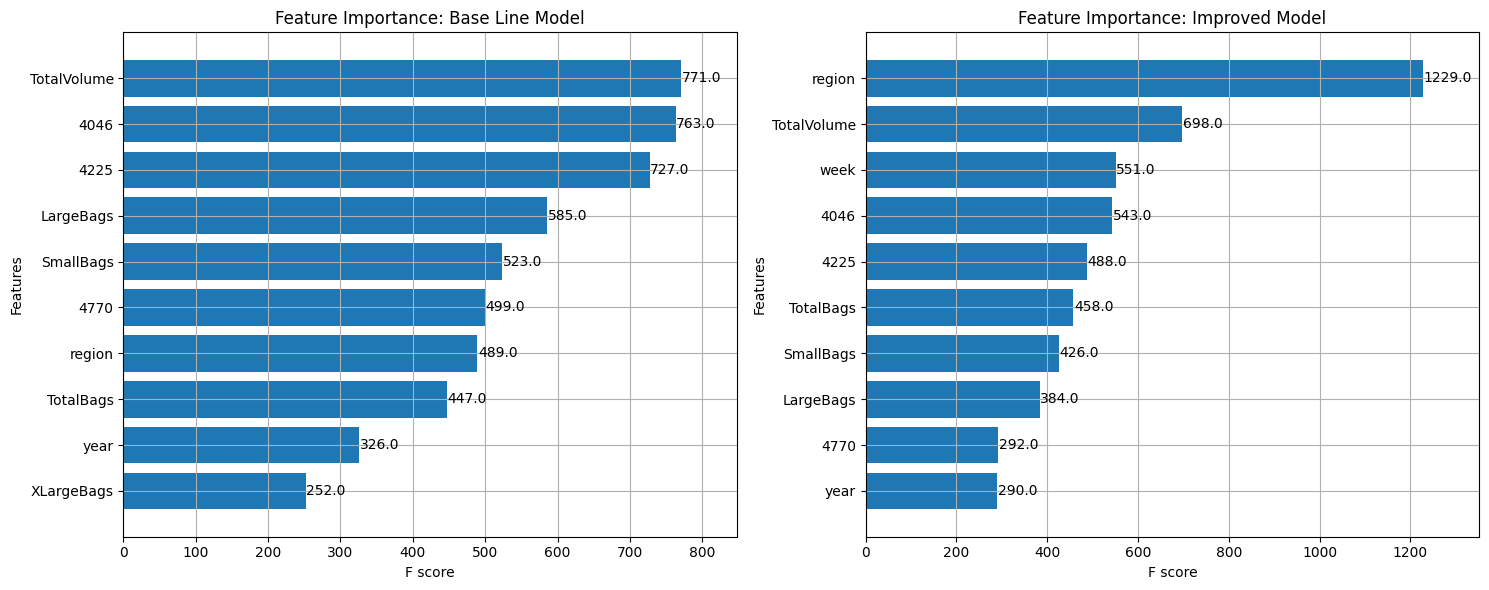

In [106]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

def plot_feature_importance(model1, model2, title1='Base Line Model', title2='Improved Model', max_features=10):
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Plot feature importance for the first model
    plot_importance(model, importance_type='weight', max_num_features=max_features, height=0.8, ax=axes[0])
    axes[0].set_title(f'Feature Importance: {title1}')

    # Plot feature importance for the second model
    plot_importance(new_model, importance_type='weight', max_num_features=max_features, height=0.8, ax=axes[1])
    axes[1].set_title(f'Feature Importance: {title2}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, new_model)


## What can we infer from the comparison above?
1. Data engineering - Our new created feature **"week" is now considered very important** by the model. That, in fact, implies ont of the main reasons for the significant improvement we witness - the **new features affect the model resoning**, utilizing the pattenrs we analaysed in part-1 regarding the relation between the time in the year and the average avocado price

2. Another interseting thing here, features "4046", and "4225" which were in top3 on the base mode, are now assigned lower importance in the new model.
Noticing the many outliers we detected in this part due to extreme values on both of those features columns, we understand how assigning high importance to them, could affect the base model performance and explain its observed shortcomings.

3. Treating the region feature as categorical resulted in its updgrade from 5st most important to the most important feature of the model.(recall - on part 1 we treated region as numerical distinct values)

In [108]:
import shap
# baseline model
shap_sample = old_X_train.sample(500)
explainer = shap.TreeExplainer(model)
shap_values = explainer(shap_sample)

# new model
shap_sample = new_X_Train.sample(500)
new_explainer = explainer = shap.TreeExplainer(new_model)
new_shap_values = new_explainer(shap_sample)

## Base-line Model:

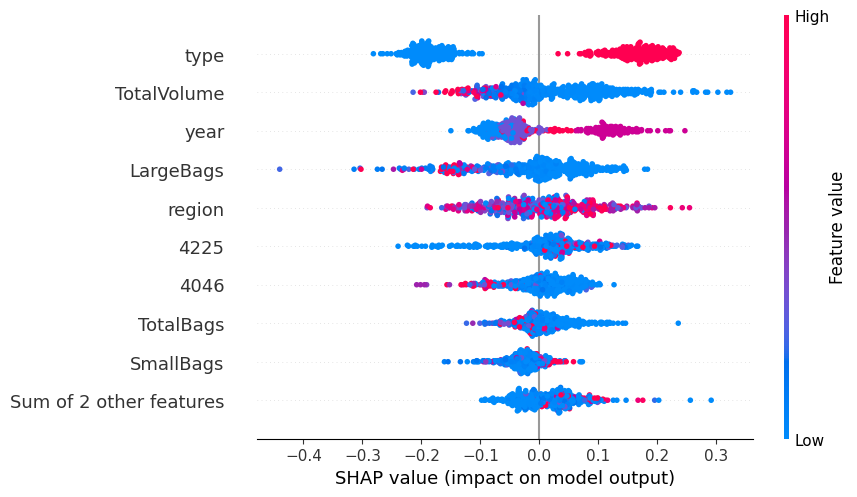

In [109]:
# show baseline model explainer
shap.plots.beeswarm(shap_values)

## Improved model:

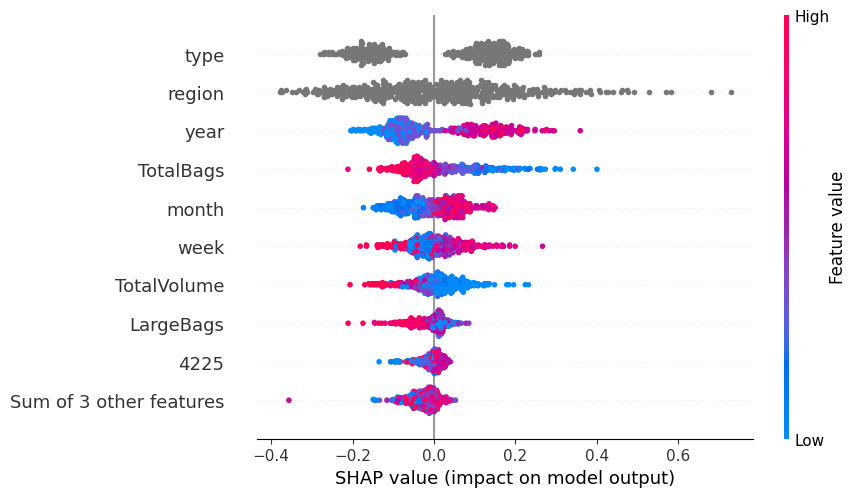

In [110]:
# show new model explainer
shap.plots.beeswarm(new_shap_values)

## What do we learn from the above?
1. Both the old and the new model, found that there's a negative correlation between TotalVolume and averagePrice (As we suspected and described on part 1). Though it seems to be more conclusive in the new model.

2. Total bags is highly important in the new model as opposed to the baseline. Further more, a clear pattern is shown here - samll values increase the model's output. This fact actually seem pretty reasonable, considering the fact that Total volume is highly correlated with Total Bags (shown also on part 1).

3. We observe no features with really extreme shap values on the new model as oppose to the baseline. This is probably due to our extensive outliers removal which created a cleaner dataset with less extreme values which were assigned high shap values in the old model

4. Week feautre in the new model well-demonstrate its influence in the visualization above. It actually shows some kind of pattern where the highest values (week numbers) are with the smallest shap values, then the low week numbers and then again the medium-high values. Namely, the season matters and affect the target column as expected from part 1 (in which we provided a clear insight and visualization of how the avgPrice changes over time)

## Let's take a close look at the residuals, maybe we can see some differences in there as well

In [ ]:
def plot_residuals(base_y_true, base_predictions, y_true, y_predictions):
    base_residuals_abs = base_y_true - base_predictions
    new_residuals_abs = y_true - y_predictions

    base_residuals_pct = (base_residuals_abs / base_y_true) * 100
    new_residuals_pct = (new_residuals_abs / y_true) * 100

    fig, ax = plt.subplots(2, 2, figsize=(16, 10))

    # Absolute Residuals: Base Model
    sns.scatterplot(x=base_predictions, y=base_residuals_abs, ax=ax[0, 0], color='blue', alpha=0.7)
    sns.lineplot(x=base_predictions, y=[0] * len(base_predictions), ax=ax[0, 0], color='black')
    ax[0, 0].set_title("Base Model Absolute Residuals")
    ax[0, 0].set_xlabel("Predictions")
    ax[0, 0].set_ylabel("Residuals")

    # Absolute Residuals: New Model
    sns.scatterplot(x=y_predictions, y=new_residuals_abs, ax=ax[0, 1], color='green', alpha=0.7)
    sns.lineplot(x=y_predictions, y=[0] * len(y_predictions), ax=ax[0, 1], color='black')
    ax[0, 1].set_title("New Model Absolute Residuals")
    ax[0, 1].set_xlabel("Predictions")
    ax[0, 1].set_ylabel("Residuals")

    # Percentage Residuals: Base Model
    sns.scatterplot(x=base_predictions, y=base_residuals_pct, ax=ax[1, 0], color='blue', alpha=0.7)
    sns.lineplot(x=base_predictions, y=[0] * len(base_predictions), ax=ax[1, 0], color='black')
    ax[1, 0].set_title("Base Model Percentage Residuals")
    ax[1, 0].set_xlabel("Predictions")
    ax[1, 0].set_ylabel("Residuals (%)")

    # Percentage Residuals: New Model
    sns.scatterplot(x=y_predictions, y=new_residuals_pct, ax=ax[1, 1], color='green', alpha=0.7)
    sns.lineplot(x=y_predictions, y=[0] * len(y_predictions), ax=ax[1, 1], color='black')
    ax[1, 1].set_title("New Model Percentage Residuals")
    ax[1, 1].set_xlabel("Predictions")
    ax[1, 1].set_ylabel("Residuals (%)")

    plt.tight_layout()
    plt.show()
plot_residuals(y_test, prediction, new_y_test, new_prediction)


## What do we understand from the above?:
1. Overall, it's well demonstrated that our improved model actually predict closer prediction than the former model
2. On the improved model (on te right), **The variance is much smaller** both in the absolute residuals as weel as in the prpotional ones.
3. Intresetingly, the model tendency to underestimate, as shown for the base line model, is also present in our improved model (as shown in the right-bottom cell).